<a href="https://colab.research.google.com/github/regiiis/dlv_group_project/blob/main/dlv_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 26 15:01:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set up

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

In [5]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df

,image_filepath,anomaly_class,image_name
13357,images/13357.jpg,No-Anomaly,13357.jpg
13356,images/13356.jpg,No-Anomaly,13356.jpg
19719,images/19719.jpg,No-Anomaly,19719.jpg
11542,images/11542.jpg,No-Anomaly,11542.jpg
11543,images/11543.jpg,No-Anomaly,11543.jpg
...,...,...,...
8488,images/8488.jpg,Vegetation,8488.jpg
8489,images/8489.jpg,Vegetation,8489.jpg
7464,images/7464.jpg,Cracking,7464.jpg
18065,images/18065.jpg,No-Anomaly,18065.jpg


In [44]:
reduced_df = df.sample(frac=0.8,random_state=200)       # random state is a seed value
train_df = reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac=0.5,random_state=200)
test_df = validation_test_df.drop(validation_df.index)

print(train_df.info())
print()
print(validation_df.info())
print()
test_df.info()

test_df.anomaly_class

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12800 entries, 19208 to 2880
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  12800 non-null  object
 1   anomaly_class   12800 non-null  object
 2   image_name      12800 non-null  object
dtypes: object(3)
memory usage: 400.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 12389 to 2391
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1600 non-null   object
 1   anomaly_class   1600 non-null   object
 2   image_name      1600 non-null   object
dtypes: object(3)
memory usage: 50.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 2358 to 14124
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1600 non-null   object
 1

2358          Diode
9560     Vegetation
17012    No-Anomaly
6147           Cell
11880    No-Anomaly
            ...    
1520          Diode
1330          Diode
4781     Cell-Multi
14401    No-Anomaly
14124    No-Anomaly
Name: anomaly_class, Length: 1600, dtype: object

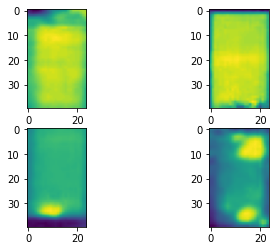

In [7]:
img1 = mpimg.imread('/content/InfraredSolarModules/images/13356.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/8488.jpg')  #Vegetation
img3 = mpimg.imread('/content/InfraredSolarModules/images/8489.jpg')  #Vegetation
img4 = mpimg.imread('/content/InfraredSolarModules/images/7464.jpg')  #Cracking

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)

## Transfer Learning

### **Feature Extraction** - without data augmentation

In [8]:
# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import os, datetime

# Shortcuts to keras if (however from tensorflow)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import layers
from IPython.display import Image

In [27]:

image_height = 40
image_width = 32
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

val_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
     )

Found 12800 validated image filenames belonging to 12 classes.
Found 1600 validated image filenames belonging to 12 classes.


In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet"
)

for layer in pre_trained_model.layers:
    layer.trainable=False
    
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 10, 128)        0     

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

model = tf.keras.models.Sequential([
    pre_trained_model,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                      

#### Compute Model

In [30]:
model.compile(loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])


logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model.fit(
train_generator,
epochs=30,
validation_data=(val_generator),
callbacks=callbacks
)

Epoch 1/30
400/400 [==============================] - 10s 22ms/step - loss: 1.5544 - accuracy: 0.5535 - val_loss: 1.5816 - val_accuracy: 0.5300
Epoch 2/30
400/400 [==============================] - 8s 21ms/step - loss: 1.2498 - accuracy: 0.6231 - val_loss: 1.4479 - val_accuracy: 0.5800
Epoch 3/30
400/400 [==============================] - 8s 21ms/step - loss: 1.1902 - accuracy: 0.6338 - val_loss: 1.1404 - val_accuracy: 0.6488
Epoch 4/30
400/400 [==============================] - 11s 28ms/step - loss: 1.1529 - accuracy: 0.6445 - val_loss: 1.0898 - val_accuracy: 0.6650
Epoch 5/30
400/400 [==============================] - 9s 22ms/step - loss: 1.1292 - accuracy: 0.6466 - val_loss: 1.1174 - val_accuracy: 0.6381
Epoch 6/30
400/400 [==============================] - 9s 23ms/step - loss: 1.1147 - accuracy: 0.6516 - val_loss: 1.1413 - val_accuracy: 0.6212
Epoch 7/30
400/400 [==============================] - 9s 21ms/step - loss: 1.0998 - accuracy: 0.6570 - val_loss: 1.0829 - val_accuracy: 0.65

#### Model Performance

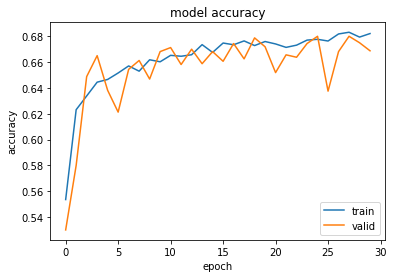

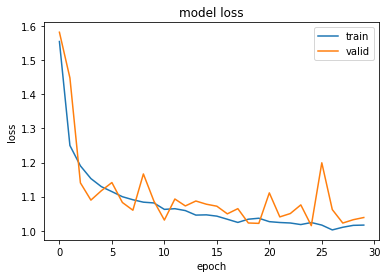

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [32]:
 model.evaluate(val_generator)

50/50 [==============================] - 1s 15ms/step - loss: 1.0388 - accuracy: 0.6687


[1.0388174057006836, 0.668749988079071]

In [ ]:
# Load the TensorBoard notebook extension on google colab
%load_ext tensorboard
%tensorboard --logdir logs

### Fine Tuning

The steps for fine-tuning are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16)
5. Jointly train both these layers and the part we added.

In [33]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 10, 128)        0     

In [34]:
# Freeze all layers until the block_5_ layers
pre_trained_model.trainable = True
for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False
    
for layer in pre_trained_model.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))  

layer name = input_2, shape = [(None, 32, 40, 3)], trainable = False
layer name = block1_conv1, shape = (None, 32, 40, 64), trainable = False
layer name = block1_conv2, shape = (None, 32, 40, 64), trainable = False
layer name = block1_pool, shape = (None, 16, 20, 64), trainable = False
layer name = block2_conv1, shape = (None, 16, 20, 128), trainable = False
layer name = block2_conv2, shape = (None, 16, 20, 128), trainable = False
layer name = block2_pool, shape = (None, 8, 10, 128), trainable = False
layer name = block3_conv1, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv2, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv3, shape = (None, 8, 10, 256), trainable = False
layer name = block3_pool, shape = (None, 4, 5, 256), trainable = False
layer name = block4_conv1, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv2, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv3, shape = (None, 4, 5, 512), train

In [36]:
model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                        

In [37]:
logdir = os.path.join("logs_fine_tuning", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model.fit(
train_generator,
epochs=30,
validation_data = val_generator,
callbacks = callbacks
)

Epoch 1/30
400/400 [==============================] - 10s 23ms/step - loss: 1.0061 - accuracy: 0.6812 - val_loss: 1.0865 - val_accuracy: 0.6431
Epoch 2/30
400/400 [==============================] - 9s 23ms/step - loss: 0.9213 - accuracy: 0.7045 - val_loss: 1.0054 - val_accuracy: 0.6837
Epoch 3/30
400/400 [==============================] - 9s 23ms/step - loss: 0.8767 - accuracy: 0.7188 - val_loss: 0.9976 - val_accuracy: 0.7013
Epoch 4/30
400/400 [==============================] - 9s 23ms/step - loss: 0.8272 - accuracy: 0.7359 - val_loss: 0.8733 - val_accuracy: 0.7219
Epoch 5/30
400/400 [==============================] - 9s 22ms/step - loss: 0.8072 - accuracy: 0.7411 - val_loss: 0.8997 - val_accuracy: 0.7206
Epoch 6/30
400/400 [==============================] - 9s 23ms/step - loss: 0.7654 - accuracy: 0.7534 - val_loss: 0.8547 - val_accuracy: 0.7219
Epoch 7/30
400/400 [==============================] - 9s 22ms/step - loss: 0.7375 - accuracy: 0.7635 - val_loss: 1.0225 - val_accuracy: 0.696

### Model Performance - With Fine Tuning

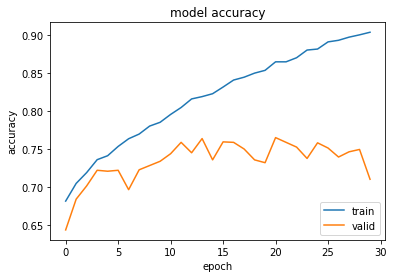

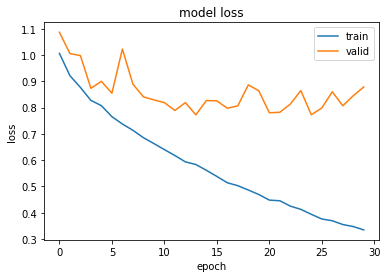

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [39]:
 model.evaluate(val_generator)

50/50 [==============================] - 1s 13ms/step - loss: 0.8784 - accuracy: 0.7100


[0.8783882260322571, 0.7099999785423279]

In [43]:
y_prob = model.predict(val_generator) 
y_classes = y_prob.argmax(axis=-1)
y_classes

array([ 3,  7,  4, ...,  3,  7, 11])

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys

num_of_test_samples = 1600

Y_pred = model.predict_generator(val_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

print()
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(val_generator.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys



Confusion Matrix
[[ 14   8   4  11   1   2   3  48   5  20   0  16]
 [ 13   5   5  10   0   1   4  49   2  18   0   6]
 [  7   6   2  11   0   2   1  50   0  16   0   3]
 [  8   5   6   9   1   2   0  53   3  16   2  12]
 [  3   0   2   3   0   0   0   3   0   4   0   2]
 [  1   1   1   2   0   1   1   9   0   1   0   3]
 [  3   0   0   2   1   0   0   7   0   2   1   2]
 [ 71  45  43  63   4   3   7 359  29  92   5  56]
 [  8   6   0   2   0   0   0  25   3  14   0   1]
 [ 14   3   3   6   0   0   1  39   4  15   0   7]
 [  2   2   0   1   0   0   0   7   0   1   0   2]
 [ 10   7   9   8   0   0   1  60   6  26   1  14]]

Classification Report
              precision    recall  f1-score   support

           0       0.09      0.11      0.10       132
           1       0.06      0.04      0.05       113
           2       0.03      0.02      0.02        98
           3       0.07      0.08      0.07       117
           4       0.00      0.00      0.00        17
           5       0.